
Attempt 1:


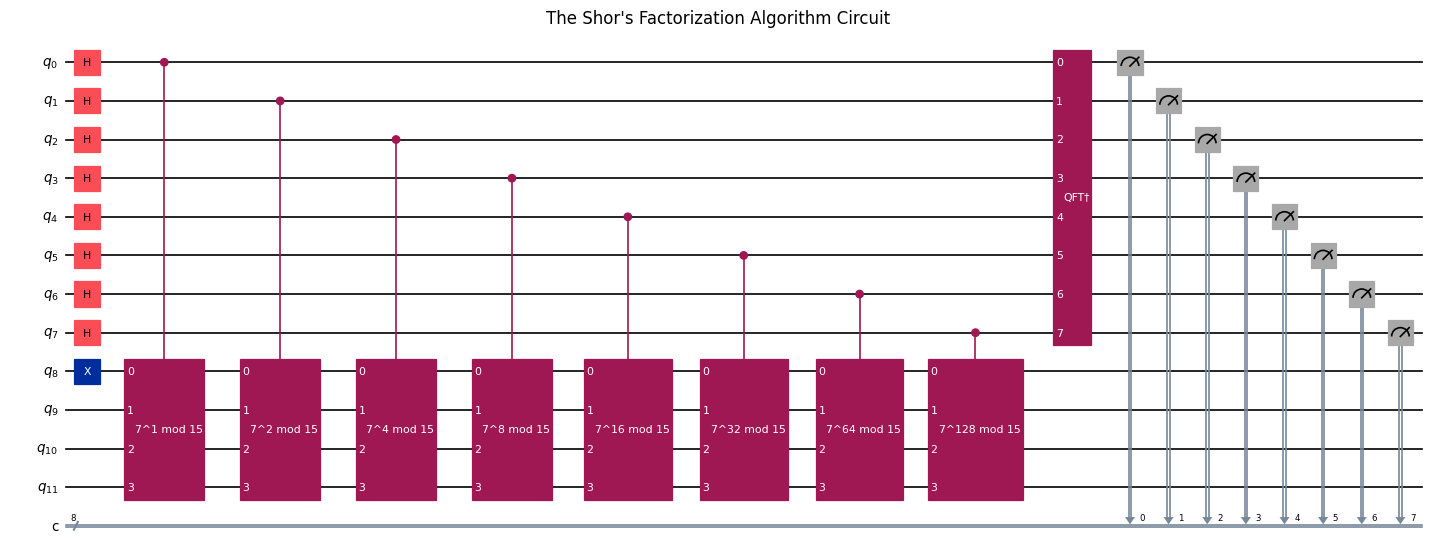

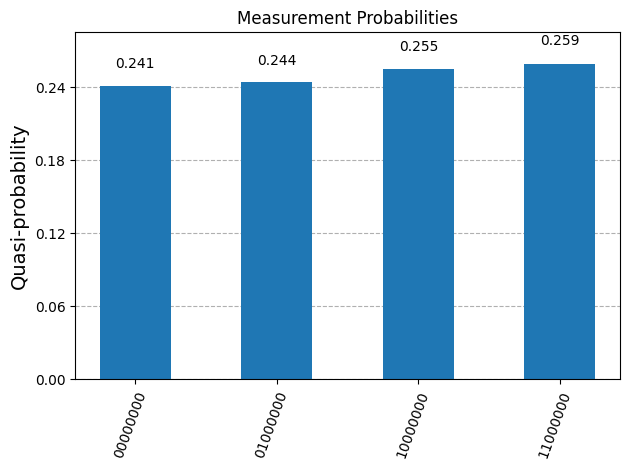

Measured: 11000000 → 192
Estimated fraction: 3/4, possible period r = 4
Factors of 15: 5, 3


(5, 3)

In [ ]:
!pip install qiskit[visualization]
!pip install qiskit-aer
!pip install qiskit qiskit-aer matplotlib

# %matplotlib inline is for Jupyter/Colab
%matplotlib inline


from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from math import gcd
from fractions import Fraction
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
from IPython.display import display, HTML

# --- Hardcoded modular exponentiation for a = 7 mod 15 ---
def c_amod15(a, power):
    """Controlled unitary for a^power mod 15 using hand-crafted permutations (for a=7 only)."""
    if a != 7:
        raise ValueError("This demo only supports a = 7 and N = 15.")

    val = pow(a, power, 15)
    qc = QuantumCircuit(4)

    # Simulate known unique responses to 7^power mod 15
    if val == 7:
        qc.x(0)
    elif val == 4:
        qc.x(1)
    elif val == 13:
        qc.x(2)
    elif val == 1:
        pass  # Identity

    gate = qc.to_gate()
    gate.name = f"{a}^{power} mod 15"
    return gate.control(1)

# --- Build Shor's circuit with controlled modular exponentiation ---
def construct_shors_circuit(a, N):
    n_count = 8
    n_work = 4
    qc = QuantumCircuit(n_count + n_work, n_count)

    # Step 1: Hadamards on counting register
    for q in range(n_count):
        qc.h(q)

    # Step 2: Initialize work register to |1>
    qc.x(n_count + 0)  # First work qubit to |1⟩

    # Step 3: Apply controlled-U gates
    for i in range(n_count):
        qc.append(c_amod15(a, 2 ** i), [i] + list(range(n_count, n_count + n_work)))

    # Step 4: Inverse QFT
    qc.append(QFT(n_count, inverse=True, do_swaps=True).to_gate(label="QFT†"), range(n_count))

    # Step 5: Measure
    qc.measure(range(n_count), range(n_count))
    return qc

# --- Extract period from measurement ---
def get_period_from_result(measured_result, N, a, n_count):
    decimal = int(measured_result, 2)
    frac = Fraction(decimal, 2 ** n_count).limit_denominator(N)
    r = frac.denominator
    print(f"Measured: {measured_result} → {decimal}")
    print(f"Estimated fraction: {frac}, possible period r = {r}")
    if pow(a, r, N) != 1:
        print(f"Failed check: {a}^{r} mod {N} ≠ 1")
        return None
    return r

# --- Shor's main algorithm ---
def shors_algorithm(N=15, a=7, shots=2048):
    n_count = 8
    qc = construct_shors_circuit(a, N)

    # Show circuit
    # Generate circuit diagram as a matplotlib figure
    fig = circuit_drawer(qc, output='mpl', justify='left', idle_wires=False, fold=-1, scale=0.6)

# Add annotations to the same figure
    ax = fig.axes[0]  # Get the axis object

# Add a title
    ax.set_title("The Shor's Factorization Algorithm Circuit")

# Show the updated plot
    display(fig)
    display(HTML("<div style='margin-top: 40px;'></div>"))


    # Simulate
    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=shots).result()
    counts = result.get_counts()

    # Plot histogram
    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}
    probabilities = OrderedDict(sorted(probabilities.items(), reverse=True))
    display(plot_histogram(probabilities, title="Measurement Probabilities"))


    # Analyze most frequent result
    for measured in sorted(counts, key=counts.get, reverse=True):
        r = get_period_from_result(measured, N, a, n_count)
        if r is not None and r % 2 == 0:
            break
        r = None

    if r is None:
        print("Could not find valid period. Try again.")
        return None

    # Compute potential factors
    plus = pow(a, r // 2) + 1
    minus = pow(a, r // 2) - 1
    factor1 = gcd(plus, N)
    factor2 = gcd(minus, N)

    if factor1 * factor2 == N and factor1 not in [1, N] and factor2 not in [1, N]:
        print(f"Factors of {N}: {factor1}, {factor2}")
        return factor1, factor2
    else:
        print("Trivial factors found. Try again.")
        return None

# --- Retry wrapper ---
def reliable_shor(N=15, a=7, retries=5):
    for attempt in range(1, retries + 1):
        print(f"\nAttempt {attempt}:")
        result = shors_algorithm(N, a)
        if result:
            return result
    print("Failed to find non-trivial factors after multiple attempts.")
    return None

# --- Run ---
reliable_shor()
